# Hate Speech Detection Using LSTM in PyTorch

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load dataset
df = pd.read_csv('labeled_data.csv')

df.shape

(24783, 7)

In [3]:
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
# from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

In [4]:
text = []
clas = []

text = df['tweet'].tolist()
clas = df['class'].tolist()

In [5]:
df = pd.DataFrame({'tweet': text, 'class': clas})

In [6]:
print(df.isnull().sum())

tweet    0
class    0
dtype: int64


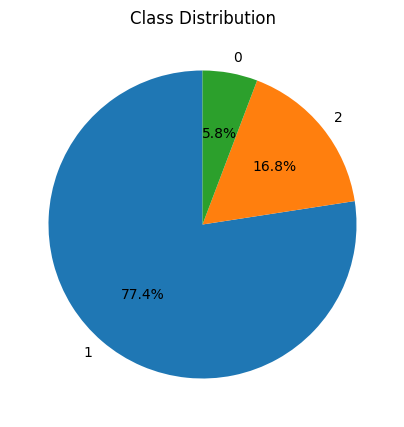

In [7]:
class_counts = df['class'].value_counts()

# Plot a pie chart
plt.figure(figsize=(5, 5))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution')
plt.show()

## Preprocessing Datasets

In [8]:
df['tweet'] = df['tweet'].apply(lambda x:x.lower())

In [9]:
punctuation_signs = list("?:!.,;|")
remove_usernames = r'@([^\s]+)'
remove_hash_no = r'#\d+'

# Remove punctuation signs
for punct_sign in punctuation_signs:
    df['tweet'] = df['tweet'].str.replace(punct_sign, '', regex=True)

# Remove usernames
df['tweet'] = df['tweet'].str.replace(remove_usernames, '', regex=True)

# Remove hashtags with numbers
df['tweet'] = df['tweet'].str.replace(remove_hash_no, '', regex=True)

In [10]:
df['tweet'] = df['tweet'].apply(lambda x: x.replace('\n', ' '))
df['tweet'] = df['tweet'].apply(lambda x: x.replace('\t', ' '))

# Replace url and symbols
df['tweet'] = df['tweet'].str.replace("    ", " ")
df['tweet'] = df['tweet'].str.replace('"', '')
df['tweet'] = df['tweet'].str.replace("!", "")
df['tweet'] = df['tweet'].str.replace("'s", "")
df['tweet'] = df['tweet'].str.replace("'", "")
df['tweet'] = df['tweet'].str.replace("`", "")
df['tweet'] = df['tweet'].str.replace("https", "")
df['tweet'] = df['tweet'].str.replace("http", "")
df['tweet'] = df['tweet'].str.replace("rt", "")
df['tweet'] = df['tweet'].str.replace("-", "")

In [11]:
df['tweet']

0           as a woman you shouldnt complain about clea...
1           boy dats coldtyga dwn bad for cuffin dat ho...
2           dawg   you ever fuck a bitch and she sta to...
3                                   she look like a tranny
4           the shit you hear about me might be true or...
                               ...                        
24778    you a muthaf***in lie &   right his tl is tras...
24779    youve gone and broke the wrong hea baby and dr...
24780    young buck wanna eat dat nigguh like i aint fu...
24781                youu got wild bitches tellin you lies
24782    ~~ruffled  ntac eileen dahlia  beautiful color...
Name: tweet, Length: 24783, dtype: object

In [12]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['tweet'] = df['tweet'].str.replace(regex_stopword, '', regex=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df.sample(5)

,tweet,class
19165,yall bitches got stop pushing away niggas ...,1
6172,name ollie bitch,1
4386,put money pussy,1
22851,thick character game gotta play skin...,1
18702,pussy still taste like mcdonald fries eat...,1


In [14]:
# Get max_count featured names in the dataset column 'tweet'
cv = CountVectorizer(max_features = 100)
X = cv.fit_transform(df['tweet']).toarray()
y = df['class']

In [15]:
cv.get_feature_names_out()

array(['aint', 'always', 'amp', 'ass', 'back', 'bad', 'better', 'bird',
       'bitch', 'bitches', 'bout', 'call', 'cant', 'cause', 'charlie',
       'come', 'cunt', 'da', 'damn', 'dat', 'day', 'dick', 'dont', 'dumb',
       'eat', 'even', 'ever', 'every', 'faggot', 'fuck', 'fuckin',
       'fucking', 'get', 'ghetto', 'girl', 'girls', 'give', 'go', 'going',
       'gonna', 'good', 'got', 'gotta', 'gt', 'hate', 'hoe', 'hoes',
       'ill', 'im', 'know', 'let', 'life', 'like', 'lil', 'little',
       'lmao', 'lol', 'look', 'love', 'make', 'man', 'money', 'need',
       'never', 'new', 'nigga', 'niggah', 'niggas', 'one', 'people',
       'pussy', 'real', 'really', 'retarded', 'right', 'said', 'say',
       'see', 'shit', 'still', 'stop', 'take', 'talk', 'tco', 'tell',
       'think', 'time', 'trash', 'twitter', 'ugly', 'wanna', 'want',
       'white', 'wit', 'would', 'ya', 'yall', 'yellow', 'yo', 'youre'],
      dtype=object)

In [16]:
# Position of words and vectorized words index check
df['tweet'][24781], X[24781], y

('youu got wild bitches tellin  lies',
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 0        2
 1        1
 2        1
 3        1
 4        1
         ..
 24778    1
 24779    2
 24780    1
 24781    1
 24782    2
 Name: class, Length: 24783, dtype: int64)

## PyTorch Implementation

In [17]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

print(torch.__version__)

# Setting up device agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.0+cu121
cuda


## Spliting Datasets

In [18]:
X.dtype, y.dtype

(dtype('int64'), dtype('int64'))

In [19]:
#  X and y are your input features and labels
X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

X, y

(tensor([[0, 1, 1,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 1, 0, 0]]),
 tensor([2, 1, 1,  ..., 1, 1, 2]))

In [20]:
X.ndim, y.ndim, X.shape, y.shape

(2, 1, torch.Size([24783, 100]), torch.Size([24783]))

In [21]:
# Splitting Datasets
train_split = int(0.8* len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train),len(y_train), len(X_test), len(y_test)

(19826, 19826, 4957, 4957)

In [22]:
# Making sure if datasets are in long types
X_train, y_train = X_train.clone().detach().long(), y_train.clone().detach().long()
X_test, y_test = X_test.clone().detach().long(), y_test.clone().detach().long()

In [23]:
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype

(torch.int64, torch.int64, torch.int64, torch.int64)

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([19826, 100]),
 torch.Size([4957, 100]),
 torch.Size([19826]),
 torch.Size([4957]))

## LSTM Neural Network Model

In [25]:
class LSTMModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    super(LSTMModel, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
    self.dropout = nn.Dropout(0.2)
    self.bn = nn.BatchNorm1d(hidden_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    embedded = self.embedding(x)
    embedded = self.dropout(embedded)
    lstm_out, _ = self.lstm(embedded)
    lstm_out = lstm_out[:, -1, :]

    # Apply batch normalization after LSTM
    lstm_out = self.bn(lstm_out)

    fc_out = self.fc(lstm_out)
    output = F.softmax(fc_out, dim=1)
    return output

## Bi-LSTM Neural Network Model

In [26]:
class BidirectionalLSTMModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, bidirectional=True, num_layers=2, dropout_rate=0.5):
    super(BidirectionalLSTMModel, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_rate, bidirectional=bidirectional)
    self.dropout = nn.Dropout(dropout_rate)
    self.bn = nn.BatchNorm1d(hidden_dim * (2 if bidirectional else 1))  # Adjust input size for bidirectional LSTM
    self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    embedded = self.embedding(x)
    embedded = self.dropout(embedded)
    lstm_out, _ = self.lstm(embedded)
    lstm_out = lstm_out[:, -1, :]

    lstm_out = self.bn(lstm_out)

    fc_out = self.fc(lstm_out)
    output = F.softmax(fc_out, dim=1)
    return output

In [27]:
vocab_size = 50000
embedding_dim = 100    # 100 for LSTM | 50 for BiDirectionalLSTM
hidden_dim = 20
output_dim = 3

# Change Model Class name if you want 'LSTMModel'
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)
model

LSTMModel(
  (embedding): Embedding(50000, 100)
  (lstm): LSTM(100, 20, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=20, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [28]:
next(model.parameters()).device

device(type='cpu')

In [29]:
# Set model usage to CUDA
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [30]:
# Loss function and optimizers
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [31]:
torch.manual_seed(42)

epochs = 50
batch_size = 64

# Placing data on CUDA
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Tracking
epoch_count = []
loss_values = []
test_loss_values = []
train_accuracies = []
test_accuracies = []

# Train loop
for epoch in range(epochs):
  model.train()
  y_pred = model(X_train)
  loss = loss_fn(y_pred, y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Calculate training accuracy
  _, predicted_train_labels = torch.max(y_pred, 1)
  train_accuracy = (predicted_train_labels == y_train).sum().item() / len(y_train)

  # Testing
  model.eval()
  with torch.inference_mode():
    test_pred = model(X_test)
    test_loss = loss_fn(test_pred, y_test)

    # Calculate test accuracy
    _, predicted_test_labels = torch.max(test_pred, 1)
    test_accuracy = (predicted_test_labels == y_test).sum().item() / len(y_test)

  # Print Training Progress
  if epoch % 5 == 0 or epoch == epochs-1:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f"Epoch: {epoch} | Train Loss: {loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuracy: {train_accuracy*100:.2f}% | Test Accuracy: {test_accuracy*100:.2f}%")

Epoch: 0 | Train Loss: 1.1041 | Test Loss: 1.1239 | Train Accuracy: 31.01% | Test Accuracy: 4.72%
Epoch: 5 | Train Loss: 1.0244 | Test Loss: 0.9345 | Train Accuracy: 68.06% | Test Accuracy: 77.89%
Epoch: 10 | Train Loss: 0.9248 | Test Loss: 0.8389 | Train Accuracy: 74.09% | Test Accuracy: 75.75%
Epoch: 15 | Train Loss: 0.8536 | Test Loss: 0.8095 | Train Accuracy: 74.57% | Test Accuracy: 75.23%
Epoch: 20 | Train Loss: 0.8216 | Test Loss: 0.8011 | Train Accuracy: 74.57% | Test Accuracy: 75.11%
Epoch: 25 | Train Loss: 0.8109 | Test Loss: 0.7963 | Train Accuracy: 74.58% | Test Accuracy: 74.90%
Epoch: 30 | Train Loss: 0.8072 | Test Loss: 0.7943 | Train Accuracy: 74.59% | Test Accuracy: 75.67%
Epoch: 35 | Train Loss: 0.8055 | Test Loss: 0.7930 | Train Accuracy: 74.60% | Test Accuracy: 75.67%
Epoch: 40 | Train Loss: 0.8047 | Test Loss: 0.7923 | Train Accuracy: 74.60% | Test Accuracy: 75.67%
Epoch: 45 | Train Loss: 0.8040 | Test Loss: 0.7913 | Train Accuracy: 74.61% | Test Accuracy: 75.67%
Epo

## Loss Curve Plot

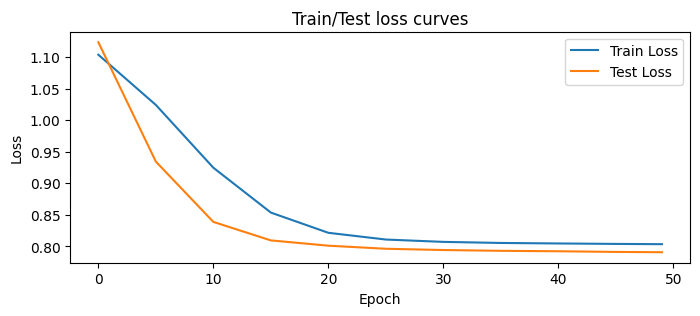

In [32]:
import matplotlib.pyplot as plt

# Plot loss curves
plt.figure(figsize=(8,3))
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test Loss")
plt.title("Train/Test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend();

## Plot Accuracy Curve

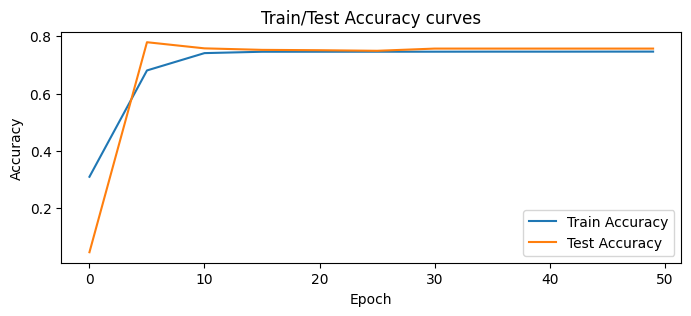

In [33]:
import matplotlib.pyplot as plt

# Plot loss curves
plt.figure(figsize=(8,3))
plt.plot(epoch_count, np.array(torch.tensor(train_accuracies).numpy()), label="Train Accuracy")
plt.plot(epoch_count, np.array(torch.tensor(test_accuracies).numpy()), label="Test Accuracy")
plt.title("Train/Test Accuracy curves")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend();

## Saving model

In [34]:
from pathlib import Path

model_path = Path('models')
model_path.mkdir(parents = True, exist_ok =True)

model_name = '00_LSTM_HateSpeech.pth'
model_save_path = model_path / model_name

print(f"Saving model to: {model_save_path}")
torch.save(obj = model.state_dict(),
           f = model_save_path)
print('Saved Successfully')

Saving model to: models/00_LSTM_HateSpeech.pth
Saved Successfully


## Loading Model

In [35]:
loaded_model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)
loaded_model.load_state_dict(torch.load(model_save_path))

# Transfer loaded model to CUDA
loaded_model.to(device)

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")

Loaded model:
LSTMModel(
  (embedding): Embedding(50000, 100)
  (lstm): LSTM(100, 20, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=20, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)
Model on device:
cuda:0


## Prediction using `X_test`

In [36]:
model.eval()

with torch.inference_mode():
  y_preds = model(X_test)

y_preds

tensor([[7.7395e-04, 9.9866e-01, 5.6325e-04],
        [7.7395e-04, 9.9866e-01, 5.6325e-04],
        [7.7395e-04, 9.9866e-01, 5.6326e-04],
        ...,
        [7.7510e-04, 9.9866e-01, 5.6454e-04],
        [7.7395e-04, 9.9866e-01, 5.6325e-04],
        [1.8890e-01, 1.7047e-03, 8.0940e-01]], device='cuda:0')

In [37]:
# Evaluate loaded model
loaded_model.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model(X_test)

y_preds == loaded_model_preds

tensor([[True, True, True],
        [True, True, True],
        [True, True, True],
        ...,
        [True, True, True],
        [True, True, True],
        [True, True, True]], device='cuda:0')

In [38]:
# Reverse class labels tensors
predicted_labels = torch.argmax(y_preds, dim=1)

predicted_labels

tensor([1, 1, 1,  ..., 1, 1, 2], device='cuda:0')

In [39]:
# Count occurrences of 0, 1, and 2
count_0 = torch.sum(predicted_labels == 0).item()
count_1 = torch.sum(predicted_labels == 1).item()
count_2 = torch.sum(predicted_labels == 2).item()

# Print the counts
print("Count of 0:", count_0)
print("Count of 1:", count_1)
print("Count of 2:", count_2)

Count of 0: 108
Count of 1: 4661
Count of 2: 188
